In [1]:
import re
import numpy as np

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics
from sklearn import neighbors

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

In [2]:
token_count = dict()
train_x = []
file = open("tweets/tweets-train-data.csv", "r")

for line in file:
    line_text = line.split(",")[0].split()
    words = []
    for word in line_text:
        if word !="":
            word = word.lower()
            words.append(word)
        
            try:
                token_count[word] += 1
            except KeyError:
                token_count[word] = 1
        
    train_x.append(words)

file.close()

train_y = []
file = open("tweets/tweets-train-targets.csv", "r")

for line in file:
    label = line.split()[0]
    train_y.append(label)

file.close()

test_x = []
file = open("tweets/tweets-test-data.csv", "r")

for line in file:
    line_txt = line.split(",")[0].split()
    words = []
    for word in line_txt:        
        if word !="":
            words.append(word.lower())
        
    test_x.append(words)

file.close()

test_y = []
file = open("tweets/tweets-test-targets.csv", "r")

for line in file:
    test_y.append(line.split()[0])

file.close()

In [3]:
rare_list = []
for (token, count) in token_count.items():
    if count==1:
        rare_list.append(token)

stop_words = []
file = open("stop_words.txt", "r")
for line in file:
    stop_words.append(line.split()[0])
file.close()

remove = rare_list + stop_words
for token in remove:
    try:
        del token_count[token]
    except KeyError:
        pass
    
vocabulary = sorted(token_count.items(), key=lambda x: x[1], reverse=True)

In [4]:
train_data = []
n_token = len(token_count)
for tweet in train_x:
    ft_vector = []
    for (k,v) in vocabulary[:100]:
        if k in tweet:
            ft_vector.append(v/n_token) #token probability
        else:
            ft_vector.append(0)
    train_data.append(ft_vector)

train = np.array(train_data)

test_data = []

for tweet in test_x:
    ft_vector = []
    for (k,v) in vocabulary[:100]:
        if k in tweet:
            ft_vector.append(v/n_token)
        else:
            ft_vector.append(0)
    test_data.append(ft_vector)

test = np.array(test_data)

In [5]:
clf = SVC(C=10, kernel='rbf', gamma=0.02)
clf.fit(train, train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
y_pred = clf.predict(test)

report = metrics.classification_report(test_y, y_pred)
accuracy = metrics.accuracy_score(test_y, y_pred)

# the support is the number of instances having the given label in y_test
print(report)
print('Accuracy: ' + str(accuracy))

              precision    recall  f1-score   support

          DT       0.59      0.86      0.70       812
          HC       0.74      0.40      0.52       799

   micro avg       0.63      0.63      0.63      1611
   macro avg       0.67      0.63      0.61      1611
weighted avg       0.67      0.63      0.61      1611

Accuracy: 0.6319056486654252


In [7]:
n_splits = 3
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

c_values = [0.1, 1, 10, 100, 1000]
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]

allResults = []

for c in c_values:
    for gamma in gamma_values:
        clf = SVC(C=c, kernel='rbf', gamma=gamma)
        
        scores = cross_validate(clf, train, train_y, cv=kfold.split(train), 
                                scoring=['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'], 
                                n_jobs=-1, return_train_score=False)
        
        allResults.append((c, gamma, scores['test_accuracy'].mean(), scores['test_precision_micro'].mean(), 
                   scores['test_recall_micro'].mean(), scores['test_f1_micro'].mean()))

In [8]:
accuracies = [accuracy for [C, gamma, accuracy, precision, recall, f1] in allResults]
best_index = np.array(accuracies).argmax()

best_c = allResults[best_index][0]
best_gamma = allResults[best_index][1]
print(best_c)
print(best_gamma)

1000
1


In [9]:
clf = SVC(C=best_c, kernel='rbf', gamma=best_gamma)
clf.fit(train, train_y)

y_pred = clf.predict(test)

report = metrics.classification_report(test_y, y_pred)
accuracy = metrics.accuracy_score(test_y, y_pred)

print (str(report) + "\n Accuracy: " + str(accuracy))

              precision    recall  f1-score   support

          DT       0.84      0.71      0.77       812
          HC       0.75      0.86      0.80       799

   micro avg       0.79      0.79      0.79      1611
   macro avg       0.79      0.79      0.79      1611
weighted avg       0.79      0.79      0.79      1611

 Accuracy: 0.7864680322780881


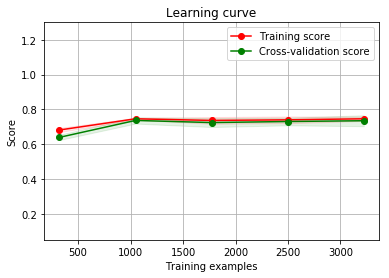

In [10]:
plt.figure()
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

clf = SVC(C=10, kernel='rbf', gamma=best_gamma)

train_sizes, train_scores, val_scores = learning_curve(clf, train, train_y, scoring='accuracy', cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")

plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.ylim(0.05,1.3)             # set bottom and top limits for y axis
plt.legend()
plt.show()

In [11]:
file = open("test_pred.txt", "w")

for label in y_pred:
    label = label + "\n"
    file.write(label)

file.close()